In [319]:
import os, re
import pandas as pd
import datetime
import nltk
import numpy as np
import gensim
from stop_words import get_stop_words
from nltk.tokenize import PunktSentenceTokenizer
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel
from wordcloud import WordCloud
from gensim import corpora, models, similarities 
from gensim.parsing.preprocessing import remove_stopwords
import spacy
import itertools
import warnings
warnings.filterwarnings("ignore")
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline
matplotlib.use('agg')
import itertools
import pickle
import pyLDAvis
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [272]:
stops = nltk.corpus.stopwords.words('english')+['can','will','also','health','healthcare','datum','data'
                                               'technology','technolog','care','busi','custom','year',]

In [273]:
#stops = get_stop_words('en')
#stops = stops +['"s',"'s",'s','can','will','also']

In [234]:
#pt = nltk.stem.PorterStemmer()

In [235]:
nlp = spacy.load('en')#, disable=['parser', 'ner'])

/Users/misun/anaconda/lib/python3.5/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/Users/misun/anaconda/lib/python3.5/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
/Users/misun/anaconda/lib/python3.5/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/Users/misun/anaconda/lib/python3.5/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/Users/m

In [236]:
#spacy.load('en')

In [237]:
rootDir = '../LDA/'
d = {}
wh = []
for dirName, subdirList, fileList in os.walk(rootDir) :
    print('Found directory: %s' % dirName)
    #print(dirName)
    #print(len(fileList))
    c = 0

    if dirName !='../LDA/.ipynb_checkpoints' and dirName != '../LDA/'\
    and dirName != '../LDA/fintech_re':
        print(dirName)
        news_name = dirName.replace('../LDA/','')
        d[news_name] = {}
        c = 0
        for fname in fileList: 
            if fname.endswith(".txt"):  
                filepath = os.path.join(dirName, fname)
                with open(filepath, 'r', -1) as input_file:
                    data = input_file.read()
                    #print(data)
                    if data != '':
                        try:                                
                            if news_name == 'healthitarticle':
                                c+=1
                                date = re.search(r'\w+\s\d{1,2}\,\s\d{4}', data).group(0)
                                date_obj = datetime.strptime(date, '%B %d, %Y')
                                tls = [item for item in data.split('\n') if item != ''and 'tagged' not in item.lower()]
                                body = re.sub(r'\w+\s\d{1,2}\,\s\d{4}\s\-\s+','', tls[3])
                                tls[3] = re.sub('LAS VEGAS – ','', body)
                                whole_text = " ".join(tls[3:]) 
                            if news_name == 'aitho':
                                c+=1
                                if fname == 'aitho_article_1792.txt':
                                    date = re.findall(r'\d{1,2}\s\w+\s\d{4}', data)[1]
                                else:
                                    date = re.search(r'\d{1,2}\s\w+\s\d{4}', data).group(0)
                                date_obj = datetime.strptime(date, '%d %b %Y')
                                tls = [item for item in data.split('\n') if item != '']
                                whole_text = " ".join(tls[2:]) 
                            if news_name == 'fintech':
                                c+=1
                                date = re.search(r'\w+\s\d{1,2}\,\s\d{4}', data).group(0)
                                date_obj = datetime.strptime(date, '%B %d, %Y')
                                tls = [item for item in data.split('\n') if item != '']
                                whole_text = " ".join(tls[2:]) 
                            if news_name == 'reinsu':
                                c +=1
                                date = re.search(r'\d{1,2}\w+\s\w+\s\d{4}', data).group(0)
                                date = re.sub(r'(?<=[0-9])(?:st|nd|rd|th)', '',date)
                                date_obj = datetime.strptime(date, '%d %B %Y')
                                tls = [item for item in data.split('\n') if item != '']
                                whole_text = " ".join(tls[2:]) 

                        except Exception as e:
                            print(news_name, fname)
                            print(e)
            d[news_name][c] = {'date':date_obj, 'text':whole_text, 
                                'whole':tls, 'filepath':filepath}

Found directory: ../LDA/
Found directory: ../LDA/.ipynb_checkpoints
Found directory: ../LDA/aitho
../LDA/aitho
Found directory: ../LDA/fintech
../LDA/fintech
Found directory: ../LDA/fintech_re
Found directory: ../LDA/healthitarticle
../LDA/healthitarticle
Found directory: ../LDA/reinsu
../LDA/reinsu


In [238]:
#[item for item in data.split('\n') if item != '' and 'tagged' not in item.lower()]
#[item for item in tp if item != '' and 'tagged' not in item.lower()]

In [239]:
#tp = d['healthitarticle'][1]['whole']
#tp

In [ ]:
for i, v in d.items():
    print(i, len(v))

In [148]:
temp = {}
for news_name, values1 in d.items():
    for number, values2 in values1.items():
        temp.setdefault('newsname', []).append(news_name)
        temp.setdefault('number', []).append(number)
        for key, value in values2.items():
            #for key, value in date.items():
            temp.setdefault(key, []).append(value)

In [149]:
df_orig = pd.DataFrame(temp)

In [150]:
df = df_orig[df_orig['newsname']!='healthitarticle']

In [151]:
df[['date','newsname','text','whole']].shape[0]

3337

In [152]:
df_clean = df.drop_duplicates(subset=['date','newsname','text'])

In [153]:
df_drop = df[df.duplicated(subset=['date','newsname','text'])]

In [154]:
df_clean['date'] = pd.to_datetime(df_clean['date'])

In [155]:
df_clean['year'] = df_clean['date'].dt.year

In [156]:
df_clean['month'] = df_clean['date'].dt.month

In [157]:
df_clean.groupby(['year','month']).count()

date  filepath  newsname  number  text  whole
year month                                               
2015 9         2         2         2       2     2      2
     10       14        14        14      14    14     14
     11        5         5         5       5     5      5
     12        4         4         4       4     4      4
2016 1         4         4         4       4     4      4
     2        23        23        23      23    23     23
     3         8         8         8       8     8      8
     4        29        29        29      29    29     29
     5        18        18        18      18    18     18
     6        11        11        11      11    11     11
     7        11        11        11      11    11     11
     8         5         5         5       5     5      5
     9         6         6         6       6     6      6
     10       20        20        20      20    20     20
     11       43        43        43      43    43     43
     12       16        16        16      16    16     16
2017 1        34        34        34      34    34     34
     2        29        29        29      29    29     29
     3        48        48        48      48    48     48
     4        37        37        37      37    37     37
     5        42        42        42      42    42     42
     6        76        76        76      76    76     76
     7        93        93        93      93    93     93
     8        71        71        71      71    71     71
     9        86        86        86      86    86     86
     10      139       139       139     139   139    139
     11       67        67        67      67    67     67
     12       53        53        53      53    53     53
2018 1       250       250       250     250   250    250
     2       293       293       293     293   293    293
     3       420       420       420     420   420    420
     4       404       404       404     404   404    404
     5       410       410       410     410   410    410
     6       347       347       347     347   347    347
     7       201       201       201     201   201    201

In [158]:
df_clean.to_csv('insuretech_newspaper_wo_health_addmonth.csv', index = False)

In [21]:
df_clean = pd.read_csv('insuretech_newspaper_wo_health.csv')

In [22]:
text_ls = list(df_clean['text'])

In [23]:
from gensim.parsing.preprocessing import stem_text, strip_punctuation, strip_punctuation2

In [24]:
total_text = text_ls

In [170]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [274]:
def tokenized_gensim(total_text):
    tokenized_text = []
    for k, text_raw in enumerate(total_text):
        text = re.sub('\n', ' ', text_raw, flags= re.IGNORECASE) 
        text = re.sub(r'\((?!k\))(?!b\))(.*?)\)',' ', text, flags= re.IGNORECASE)
        try:
            tokens = [word for sent in nltk.sent_tokenize(text) \
              for word in nltk.word_tokenize(sent) if word.lower() not in stops]              
            filtered_tokens = []
            for token in tokens:
                if re.search('[a-zA-Z]', token):
                    token = re.sub(r'[^\w\s]', '', token)
                    filtered_tokens.append(token.lower())
            stems = [stemmer.stem(t) for t in filtered_tokens if t not in stops]
            stems = [word for word in stems if word not in stops]
            tokenized_text.append(stems)
        except Exception as e:
            print(e)
            print(k)
    return tokenized_text

In [289]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stops] for doc in texts]

def make_bigrams(bigram_mod, texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):#, 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        #print(sent)
        doc = nlp(" ".join(sent))
        #print(doc)
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ not in stops])
    return texts_out

In [290]:
# Tokenized, remove stop words, stemming the whole texts
%time data_words = tokenized_gensim(total_text)

CPU times: user 1min 17s, sys: 1.14 s, total: 1min 18s
Wall time: 1min 20s


In [291]:
# Build the bigram and trigram models
%time bigram = gensim.models.Phrases(data_words,\
                                     min_count=5, threshold=10) 
# higher threshold fewer phrases.
%time trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
%time bigram_mod = gensim.models.phrases.Phraser(bigram)
%time trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 3.64 s, sys: 185 ms, total: 3.82 s
Wall time: 3.93 s
CPU times: user 11.3 s, sys: 226 ms, total: 11.6 s
Wall time: 11.7 s
CPU times: user 13.1 s, sys: 113 ms, total: 13.2 s
Wall time: 13.5 s
CPU times: user 16.6 s, sys: 180 ms, total: 16.8 s
Wall time: 17.1 s


In [292]:
# Remove Stop Words
%time data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
%time data_words_bigrams = make_bigrams(bigram_mod, data_words_nostops)

CPU times: user 6.5 s, sys: 199 ms, total: 6.7 s
Wall time: 6.84 s
CPU times: user 4.97 s, sys: 179 ms, total: 5.15 s
Wall time: 5.23 s


In [293]:
# Form Trigrams
%time data_words_trigrams = make_trigrams(data_words_nostops)

CPU times: user 10.4 s, sys: 235 ms, total: 10.6 s
Wall time: 10.8 s


In [294]:
#len(data_lemmatized_tri[100])

In [280]:
# Do lemmatization keeping only noun, adj, vb, adv
print(datetime.now())
%time data_lemmatized = lemmatization(data_words_bigrams,\
                                      allowed_postags=['NOUN'])#, 'ADJ', 'VERB', 'ADV'])
print(datetime.now())

2018-07-18 23:43:05.665090
CPU times: user 6min 25s, sys: 1min 2s, total: 7min 28s
Wall time: 5min 4s
2018-07-18 23:48:09.908179


In [281]:
# Do lemmatization keeping only noun, adj, vb, adv with tri
print(datetime.now())
%time data_lemmatized_tri = lemmatization(data_words_trigrams,\
                                      allowed_postags=['NOUN'])
print(datetime.now())

2018-07-18 23:48:09.929248
CPU times: user 6min 17s, sys: 60 s, total: 7min 17s
Wall time: 4min 51s
2018-07-18 23:53:01.392680


In [295]:
print(datetime.now())
#create a Gensim dictionary from the texts
%time dictionary= corpora.Dictionary(data_lemmatized_tri)

print(datetime.now())
#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
%time dictionary.filter_extremes(no_below=5, no_above=0.6)
print(datetime.now())

2018-07-19 00:02:53.395872
CPU times: user 1.12 s, sys: 116 ms, total: 1.24 s
Wall time: 1.37 s
2018-07-19 00:02:54.771760
CPU times: user 177 ms, sys: 88.8 ms, total: 266 ms
Wall time: 326 ms
2018-07-19 00:02:55.099745


In [270]:
dicls = list(dictionary.values())

In [ ]:
for i, tx in enumerate(data_lemmatized_tri):
    if 'databig' in tx:
        print(i)

In [ ]:
total_text[3836]

In [ ]:
# for k, v in dictionary.token2id.items():
#     print(k, v)

In [296]:
#convert the dictionary to a bag of words corpus for reference
%time corpus = [dictionary.doc2bow(text) for text in data_lemmatized_tri]

CPU times: user 621 ms, sys: 21 ms, total: 642 ms
Wall time: 663 ms


In [181]:
#data_lemmatized_tri[0]

In [297]:
####### LDA model
%time ldamodel = models.LdaModel(corpus, num_topics=10, \
                                   id2word=dictionary, update_every=5,\
                                 chunksize=1000, passes=20)

CPU times: user 1min 19s, sys: 605 ms, total: 1min 19s
Wall time: 1min 19s


In [298]:
# Get the topic related words 
topics_matrix = ldamodel.show_topics(formatted=False, num_words=10, num_topics=10)
topics_matrix = np.array(topics_matrix, dtype=object)
topic_words = topics_matrix[:,1]

allls = []
allls1 = []
for k in range(len(topic_words)):
    wordls = []
    for i, v in topic_words[k]:
        wordls.append(i)
    print(wordls)
    allls.append(wordls)
    allls1.append([wordls])

['blockchain', 'platform', 'investor', 'market', 'trade', 'fund', 'cryptocurr', 'project', 'invest', 'network']
['platform', 'product', 'manag', 'use', 'market', 'system', 'user', 'iot', 'brand', 'process']
['fintech', 'innov', 'bank', 'event', 'partner', 'financi', 'digit', 'support', 'financ', 'group']
['regul', 'work', 'market', 'process', 'system', 'time', 'manag', 'use', 'peopl', 'way']
['market', 'percent', 'organ', 'client', 'sale', 'use', 'product', 'digit', 'servic', 'help']
['bank', 'payment', 'consum', 'use', 'servic', 'financi', 'account', 'money', 'user', 'peopl']
['market', 'risk', 'innov', 'drone', 'product', 'model', 'digit', 'use', 'oper', 'potenti']
['game', 'platform', 'design', 'use', 'content', 'world', 'user', 'product', 'creat', 'blockchain']
['innov', 'system', 'robot', 'research', 'product', 'team', 'artifici_intellig', 'design', 'work', 'china']
['platform', 'user', 'cloud', 'servic', 'transact', 'use', 'cryptocurr', 'payment', 'process', 'blockchain']


In [ ]:
pd.DataFrame(allls)

In [268]:
dataprepared = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(dataprepared)

In [ ]:
pyLDAvis.save_html(dataprepared, 'lda_tri.html')

In [192]:
## SAVE 
dictionary.save('dictionary_tri.dict')
corpora.MmCorpus.serialize('corpus_tri.mm', corpus)

In [193]:
## SAVE TEXTS
with open("data_lemmetized_tri.txt", "wb") as fp:   #Pickling
    pickle.dump(data_lemmatized, fp)

In [194]:
### SAVE MODEL
ldamodel.save('ldamodel_tri.model')

In [ ]:
## LOAD
dictionary = gensim.corpora.Dictionary.load('dictionary_tri.dict')
corpus = gensim.corpora.MmCorpus('corpus_tri.mm')
ldamodel = gensim.models.ldamodel.LdaModel.load('ldamodel_tri.model')
with open("data_lemmetized_tri.txt",'rb')as f:
    data_lemmatized = pickle.load(f)
    f.close()

In [ ]:
dictionary.num_pos

In [ ]:
dictionary.num_nnz

# Finding optimal number of topics

In [300]:
def compute_optimal_tp_num(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus s
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    parameter_list = list(range(0, limit, 1))
    parameter_list[0] = start
    grid ={}
    cv_dic = {}
    for num_topics in parameter_list:
        print(num_topics)

        model = models.LdaModel(corpus, num_topics=num_topics,\
                                id2word=dictionary, \
                                      update_every=5, chunksize=1000,  passes=20)
        model_list.append(model)
        perplex = model.log_perplexity(corpus, total_docs=len(corpus))
        grid[num_topics]=[]
        grid[num_topics].append(perplex)
        coherencemodel = CoherenceModel(model=model, texts=texts,\
                                              dictionary=dictionary, coherence='c_v')
        cv_dic[num_topics]=[]
        cv_dic[num_topics].append(coherencemodel.get_coherence())

    return model_list, cv_dic, grid

In [301]:
%time model_list_rev, coherence_values_rev, grid_rev = compute_optimal_tp_num(dictionary=dictionary,\
                                                                           corpus=corpus,\
                                                       texts=data_lemmatized, start=2, limit=20, step=1)

2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
CPU times: user 26min 44s, sys: 13.8 s, total: 26min 58s
Wall time: 29min 48s


In [302]:
coherence_values_rev

{1: [0.27252519357853244],
 2: [0.34050911593694394],
 3: [0.36173080024425014],
 4: [0.34448008599415314],
 5: [0.3597127641761845],
 6: [0.3401495910817798],
 7: [0.34994444486929444],
 8: [0.3462317912849058],
 9: [0.34979678856783336],
 10: [0.3544097842748475],
 11: [0.3488714767319848],
 12: [0.34791851119821565],
 13: [0.3452197335378479],
 14: [0.34352967917771077],
 15: [0.37586510539682816],
 16: [0.3592435175707311],
 17: [0.34572533178029685],
 18: [0.34392761204593],
 19: [0.3607389475152357]}

In [303]:
grid_rev

{1: [-7.517850422734763],
 2: [-7.452144283098647],
 3: [-7.426529892461012],
 4: [-7.422992259687008],
 5: [-7.412516645750574],
 6: [-7.41233256468423],
 7: [-7.414573089389687],
 8: [-7.403280279676017],
 9: [-7.419954640033172],
 10: [-7.416463520919405],
 11: [-7.407529605558303],
 12: [-7.425312112456133],
 13: [-7.428444424240932],
 14: [-7.437714931406548],
 15: [-7.429508993144258],
 16: [-7.435768962029582],
 17: [-7.43705378209655],
 18: [-7.468422479329192],
 19: [-7.446722924321771]}

([<matplotlib.axis.XTick at 0x140fb1cf8>,
 <a list of 19 Text xticklabel objects>)

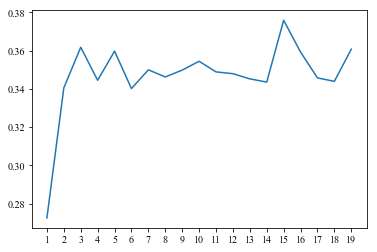

In [317]:
# Show CV
#x = range(start, limit, step)
dfcv = pd.DataFrame(coherence_values_rev)

axcv = plt.figure(figsize=(6,4)).add_subplot(111)
plt.plot(dfcv.iloc[0].transpose())
plt.xticks(list(range(1,20,1)))

([<matplotlib.axis.XTick at 0x140e79208>,
 <a list of 19 Text xticklabel objects>)

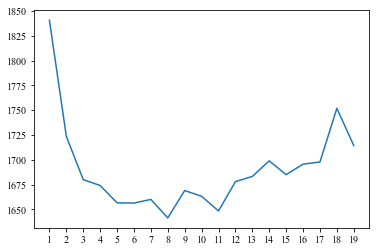

In [318]:
# perplexity
dfp = pd.DataFrame(grid_rev)
plt.plot(np.exp(-dfp.iloc[0].transpose()))
plt.xticks(list(range(1,20,1)))

In [312]:
dfp.iloc[0][1]

1    -7.517850
2    -7.452144
3    -7.426530
4    -7.422992
5    -7.412517
6    -7.412333
7    -7.414573
8    -7.403280
9    -7.419955
10   -7.416464
11   -7.407530
12   -7.425312
13   -7.428444
14   -7.437715
15   -7.429509
16   -7.435769
17   -7.437054
18   -7.468422
19   -7.446723
Name: 0, dtype: float64

In [315]:
#np.exp(7.517)

# simple_process


In [ ]:
# Build the bigram and trigram models
%time bigram2 = gensim.models.Phrases(tokenized_text,\
                                     min_count=5, threshold=100) 
# higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
%time bigram_mod2 = gensim.models.phrases.Phraser(bigram2)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
# Remove Stop Words
%time data_words_nostops2 = remove_stopwords(tokenized_text)
# Form Bigrams
%time data_words_bigrams2 = make_bigrams(bigram_mod2, data_words_nostops2)

In [ ]:
# Do lemmatization keeping only noun, adj, vb, adv
%time data_lemmatized2 = lemmatization(data_words_bigrams2,\
                                      allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
#create a Gensim dictionary from the texts
%time dictionary2= corpora.Dictionary(data_lemmatized2)
#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
%time dictionary2.filter_extremes(no_below=5, no_above=0.7)

In [ ]:
#convert the dictionary to a bag of words corpus for reference
%time corpus2 = [dictionary2.doc2bow(text2) for text2 in data_lemmatized2]

In [ ]:
####### LDA model
%time ldamodel2 = models.LdaModel(corpus2, num_topics=20, \
                                   id2word=dictionary2, update_every=5,\
                                 chunksize=500, passes=20)

In [ ]:
# Get the topic related words 
topics_matrix2 = ldamodel2.show_topics(formatted=False, num_words=15, num_topics=15)
topics_matrix2 = np.array(topics_matrix2, dtype=object)
topic_words2 = topics_matrix2[:,1]

allls2 = []
allls12 = []
for k2 in range(len(topic_words2)):
    wordls2 = []
    for i2, v2 in topic_words2[k2]:
        wordls2.append(i2)
    print(wordls2)
    allls.append(wordls2)
    allls1.append([wordls2])

In [ ]:
dataprepared2 = pyLDAvis.gensim.prepare(ldamodel2, corpus2, dictionary2)
pyLDAvis.display(dataprepared2)

# calculate topic distribution

In [70]:
from __future__ import absolute_import
import funcy as fp
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from past.builtins import xrange
#from . import prepare as vis_prepare


def _extract_data(topic_model, corpus, dictionary, doc_topic_dists=None):
    import gensim
    if not gensim.matutils.ismatrix(corpus):
        corpus_csc = gensim.matutils.corpus2csc(corpus, num_terms=len(dictionary))
    else:
        corpus_csc = corpus
        # Need corpus to be a streaming gensim list corpus for len and inference functions below:
        corpus = gensim.matutils.Sparse2Corpus(corpus_csc)

    vocab = list(dictionary.token2id.keys())
     # TODO: add the hyperparam to smooth it out? no beta in online LDA impl.. hmm..
    # for now, I'll just make sure we don't ever get zeros...
    beta = 0.01
    fnames_argsort = np.asarray(list(dictionary.token2id.values()), dtype=np.int_)
    term_freqs = corpus_csc.sum(axis=1).A.ravel()[fnames_argsort]
    term_freqs[term_freqs == 0] = beta
    doc_lengths = corpus_csc.sum(axis=0).A.ravel()

    assert term_freqs.shape[0] == len(dictionary), 'Term frequencies and dictionary have different shape {} != {}'.format(term_freqs.shape[0], len(dictionary))
    assert doc_lengths.shape[0] == len(corpus), 'Document lengths and corpus have different sizes {} != {}'.format(doc_lengths.shape[0], len(corpus))

    if hasattr(topic_model, 'lda_alpha'):
        num_topics = len(topic_model.lda_alpha)
    else:
        num_topics = topic_model.num_topics

    if doc_topic_dists is None:
        # If its an HDP model.
        if hasattr(topic_model, 'lda_beta'):
            gamma = topic_model.inference(corpus)
        else:
            gamma, _ = topic_model.inference(corpus)
        doc_topic_dists = gamma / gamma.sum(axis=1)[:, None]
    else:
        if isinstance(doc_topic_dists, list):
            doc_topic_dists = gensim.matutils.corpus2dense(doc_topic_dists, num_topics).T
        elif issparse(doc_topic_dists):
            doc_topic_dists = doc_topic_dists.T.todense()
        doc_topic_dists = doc_topic_dists / doc_topic_dists.sum(axis=1)

    assert doc_topic_dists.shape[1] == num_topics, 'Document topics and number of topics do not match {} != {}'.format(doc_topic_dists.shape[1], num_topics)

    # get the topic-term distribution straight from gensim without
    # iterating over tuples
    if hasattr(topic_model, 'lda_beta'):
        topic = topic_model.lda_beta
    else:
        topic = topic_model.state.get_lambda()
    topic = topic / topic.sum(axis=1)[:, None]
    topic_term_dists = topic[:, fnames_argsort]

    assert topic_term_dists.shape[0] == doc_topic_dists.shape[1]

    d =  {'topic_term_dists': topic_term_dists, 'doc_topic_dists': doc_topic_dists,
           'doc_lengths': doc_lengths, 'vocab': vocab, 'term_frequency': term_freqs}
    return d

In [71]:
do = _extract_data(ldamodel, corpus, dictionary)

In [72]:
dtt = pd.DataFrame(do['doc_topic_dists']).reset_index()

In [73]:
dtt['year'] = df_clean['year']

In [74]:
dttm = pd.melt(dtt, id_vars=['index','year'], value_vars=[0,1,2,3,4,5,6,7,8,9])

In [75]:
dttm.rename(columns={'index':'doc_index','variable':'topic_no','value':'topic_weight'}, inplace = True)

In [76]:
dtm1 = dttm.pivot(index='doc_index', columns='topic_no', values='topic_weight').fillna(0)

In [77]:
dtm2 = dtm1.div(dtm1.sum(axis=1), axis=0)

# Shift back to a long dataframe
dt_norm2 = dtm2.stack().reset_index()
dt_norm2.columns = ['doc_index', 'topic_id', 'norm_topic_weight']

In [78]:
len(text_ls)

3319

In [79]:
dt_norm21 = dt_norm2.merge(dttm[['year','doc_index']] ,on = 'doc_index').drop_duplicates()

In [80]:
#text_ls[674]

In [81]:
#wh[235]

In [82]:
max_df = dt_norm21[dt_norm21.groupby(['doc_index'])['norm_topic_weight'].transform(max) == dt_norm21['norm_topic_weight']]

In [83]:
topic1 = max_df[max_df['topic_id'] == 0]
topic1.sort_values('norm_topic_weight', ascending=False)

,doc_index,topic_id,norm_topic_weight,year
181000,1810,0,0.995566,2018
317100,3171,0,0.995160,2018
294400,2944,0,0.994943,2018
255400,2554,0,0.994642,2018
290400,2904,0,0.994609,2018
243700,2437,0,0.994303,2018
289300,2893,0,0.994266,2018
174400,1744,0,0.994192,2018
138500,1385,0,0.993834,2018
250600,2506,0,0.993332,2018


In [84]:
max_counts = max_df[['doc_index', 'year', 'topic_id']].groupby(['year', 'topic_id']).agg({'doc_index' : 'count'}).reset_index()
max_counts.columns = ['year', 'topic_id', 'max_count']

In [85]:
# Count the number of individual documents per year
total_docs = max_df[['year', 'doc_index']].groupby('year').agg({'doc_index' : 'count'}).reset_index()
total_docs.columns = ['year', 'total_docs']

In [86]:
#total_docs

In [87]:
# Combine the two dataframes
max_counts = max_counts.merge(total_docs, on='year', how='left')

In [88]:
max_counts['prevalence'] = max_counts['max_count']/max_counts['total_docs']


In [89]:
cm = plt.cm.get_cmap('tab10')
cm_skip = [cm.colors[i] for i in range(len(cm.colors))]

In [92]:
xi = [
 2015,
 2016,
 2017,
2018]

In [93]:
# ### TOPIC PREVALENCE
# #for key, data in max_counts.groupby('topic_id'):
# for i in range(0,10):
#     data = dy.merge(max_counts[max_counts['topic_id'] == i],
#                     on = 'year', how = 'left').fillna(0)
#     ax3 = data.plot(x='year', y='prevalence', 
#               label=key, color = cm_skip[i], legend = False, figsize = (11,2))
#     ax3.set_ylim(0,0.5)
#     #ax3.set_xlim(-0.5,0.5)
#     ax3.set_facecolor("white")
#     ax3.spines['left'].set_visible(False)
#     ax3.spines['right'].set_visible(False)
#     ax3.spines['top'].set_visible(False)
#     #ax2.set_ylim(0,250)
#     ax3.set_xlabel('')
#     plt.xticks(data['year'])
#     name = "Topic #" + str(i+1) +'pv_by_year21'
#     plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
#     #plt.savefig('Figures/'+str(name)+'.png',dpi=800,facecolor='w',bbox_inches = 'tight')    
#     #plt.close()

In [100]:
#max_counts.groupby('topic_id').count()
for key, data in max_counts.groupby('topic_id'):
    print(data)

    year  topic_id  max_count  total_docs  prevalence
6   2016         0          2         194    0.010309
16  2017         0         30         775    0.038710
26  2018         0        280        2325    0.120430
    year  topic_id  max_count  total_docs  prevalence
7   2016         1         12         194    0.061856
17  2017         1         31         775    0.040000
27  2018         1         84        2325    0.036129
    year  topic_id  max_count  total_docs  prevalence
0   2015         2          1          25    0.040000
8   2016         2          6         194    0.030928
18  2017         2         63         775    0.081290
28  2018         2        269        2325    0.115699
    year  topic_id  max_count  total_docs  prevalence
1   2015         3         17          25    0.680000
9   2016         3         85         194    0.438144
19  2017         3        182         775    0.234839
29  2018         3        169        2325    0.072688
    year  topic_id  max_coun

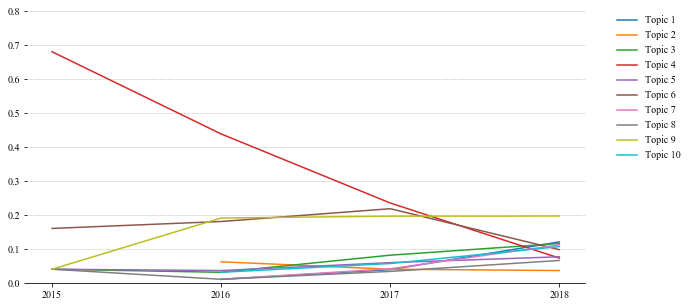

In [106]:
fig, ax4 =plt.subplots()
mylabels = ['Topic 1','Topic 2',
           'Topic 3','Topic 4',
           'Topic 5','Topic 6',
           'Topic 7','Topic 8',
           'Topic 9','Topic 10']
for key, data in max_counts.groupby('topic_id'):
    #data.plot(x='year', y='prevalence', ax=ax, label=key)
    #data = nn1
    ax4 = data.plot(x='year', y='prevalence', ax = ax4,
              label=key, color = cm_skip[key], figsize = (10,5))
    ax4.set_ylim(0,0.8)
    #ax3.set_xlim(-0.5,0.5)
    ax4.set_facecolor("white")
    ax4.spines['left'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    #ax2.set_ylim(0,250)
    ax4.set_xlabel('')
    plt.xticks(xi)
    #plt.xticks(data['year'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
               labels=mylabels,frameon=False)
    #name = str(i+1) +'pv_by_p'
    plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
    #plt.savefig('Figures/'+'90-97.png', dpi=800,facecolor='w',bbox_inches='tight')    
    #plt.close()

In [103]:
pd.DataFrame(allls)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,platform,user,system,video,use,game,product,mobil,design,featur,market,custom,power,app,connect
1,custom,consum,servic,use,chatbot,user,attack,time,payment,threat,app,merchant,devic,network,email
2,platform,team,work,use,innov,cloud,drone,manag,product,help,enterpris,custom,research,world,design
3,bank,fintech,innov,peopl,financi,london,regul,market,event,world,year,sector,work,startup,digit
4,market,custom,product,platform,percent,digit,servic,use,consum,person,autom,partner,report,manag,innov
5,investor,market,risk,fund,invest,innov,product,capit,model,manag,platform,use,group,growth,sector
6,robot,product,platform,iot,system,manag,intellig,custom,oper,research,manufactur,innov,use,artifici_intellig,china
7,custom,brand,platform,market,sale,content,team,digit,product,consum,engag,partner,success,use,blockchain
8,blockchain,platform,cryptocurr,transact,use,market,payment,trade,system,user,process,project,network,financi,exchang
9,client,manag,platform,innov,process,organ,custom,servic,help,partner,insight,system,team,support,capabl


# Graph

In [ ]:
NUMDOCS = 60 # number of subreddits OR number of BBC documents per category
NUMTOPICS = 10
def toVector(l):
    ''' inserts 0s for unrepresented topics in a document
        input: return value from ldamodel.get_document_topics(corpus[i])
        output: document topics with 0s for unrepresented topics'''
    ret = []
    t = 0
    for i in range(NUMTOPICS):
        if t == len(l):
            ret += [0]
        elif l[t][0] == i + 1:
            ret += [l[t][1]]
            t = t + 1
        else:
            ret += [0]
    return ret

In [ ]:
#text_ls#

In [ ]:
EPS = 0.001
numDocs = len(text_ls)
# note: this can take a long time on large corpora
similarity = [[0 for x in range(numDocs)] for y in range(numDocs)]

for i in range(numDocs):
    itops = toVector(ldamodel.get_document_topics(corpus[i]))
    for j in range(numDocs)[i:]:
        jtops = toVector(ldamodel.get_document_topics(corpus[j]))
        sim = 1.0 - gensim.matutils.hellinger(itops, jtops)
        sim = min(sim + EPS, 1.0)
        
        similarity[i][j] = sim


In [ ]:
type(similarity)

In [ ]:
import pickle

In [ ]:
with open('similarity','wb') as f:
    pickle.dump(similarity,f)

In [ ]:
d = pickle.load(open('similarity', 'rb'))

In [ ]:
len(d)

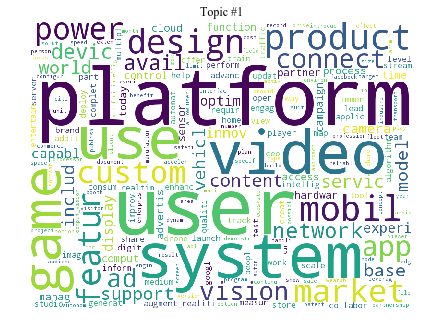

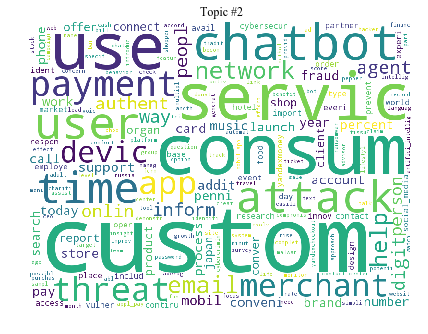

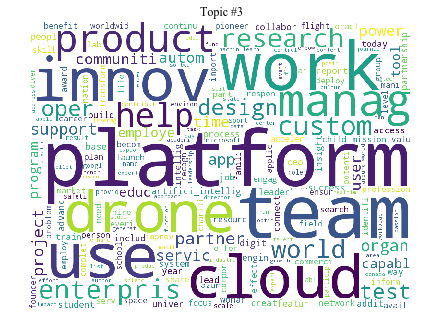

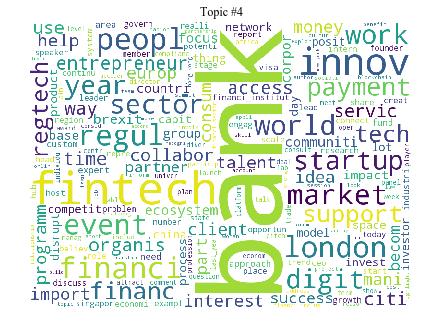

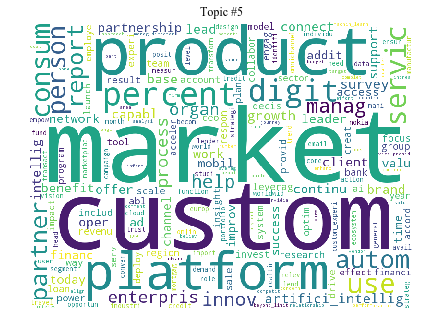

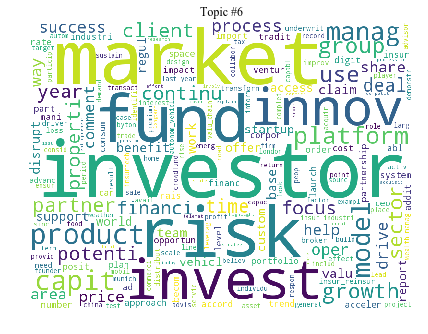

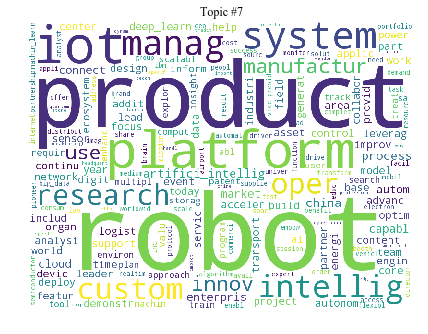

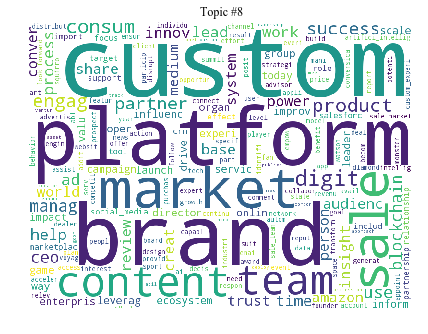

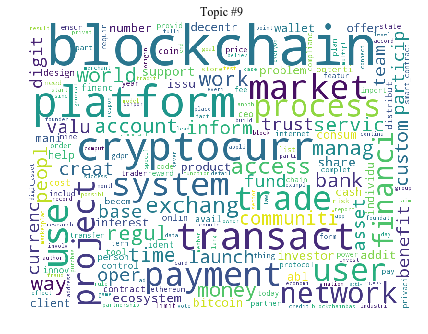

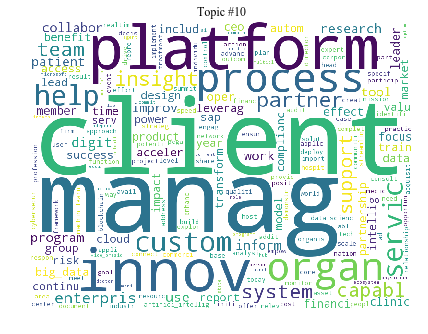

In [108]:
# Wordclouds
wc = WordCloud(
    background_color="white",
    max_words=200,
    width=800,
    height=600,
    stopwords= stops#,
    #colormap = "Greens"#stopwords.words('english')
)
#WordCloud().fit_words(dict(lda.show_topic(t, 200)))
for t in range(ldamodel.num_topics):
    name = "Topic #" + str(t+1)
    plt.figure().subplots_adjust(bottom=0, top=1, left=0, right=1)
    plt.imshow(wc.fit_words(dict(ldamodel.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t+1))
    
    #plt.savefig(str(name)+'.png', dpi=300,facecolor='w',bbox_inches="tight", pad_inches = 0)
    #plt.close()
    #plt.close()
    #plt.show()